In [28]:
import torch
import numpy as np
import os, sys, glob, copy
import matplotlib.pyplot as plt
import PIL.Image as Image
import pathlib
sys.path.insert(0, "/home/cfoley_waller/defocam/SpectralDefocusCam")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


sys.path.insert(0, "../")
import train
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.precomp_dataset as ds
from models.get_model import get_model

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
trained_weights_path = "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch1_config.yml/2024_03_14_16_55_48/saved_model_ep26_testloss_0.0708207258216615.pt"
config_path = os.path.join(pathlib.Path(trained_weights_path).parent, "training_config.yml")

In [43]:
config = helper.read_config(config_path)
num_ims = config["forward_model_params"]["stack_depth"]
config["device"] = "cuda:1"
device = torch.device(config["device"])
print(torch.cuda.get_device_name(device))
a = torch.tensor([1], device = config['device'])

config["forward_model_params"]["operations"]['adj_mask_noise'] = False
config["forward_model_params"]["operations"]['fwd_mask_noise'] = False

NVIDIA RTX A6000


In [44]:
config["data_precomputed"] = False
config["preload_weights"] = True
config["checkpoint_dir"] = trained_weights_path

model = train.get_model(config=config, device=device)
model.eval()
print(f"Model using: {torch.cuda.get_device_name(device)}")

print(model.model1.passthrough)
model.model1.operations

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 95.70it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Model using: NVIDIA RTX A6000
False


{'adj_mask_noise': False,
 'adjoint': False,
 'fwd_mask_noise': False,
 'sim_blur': False,
 'sim_meas': True,
 'spectral_pad': False}

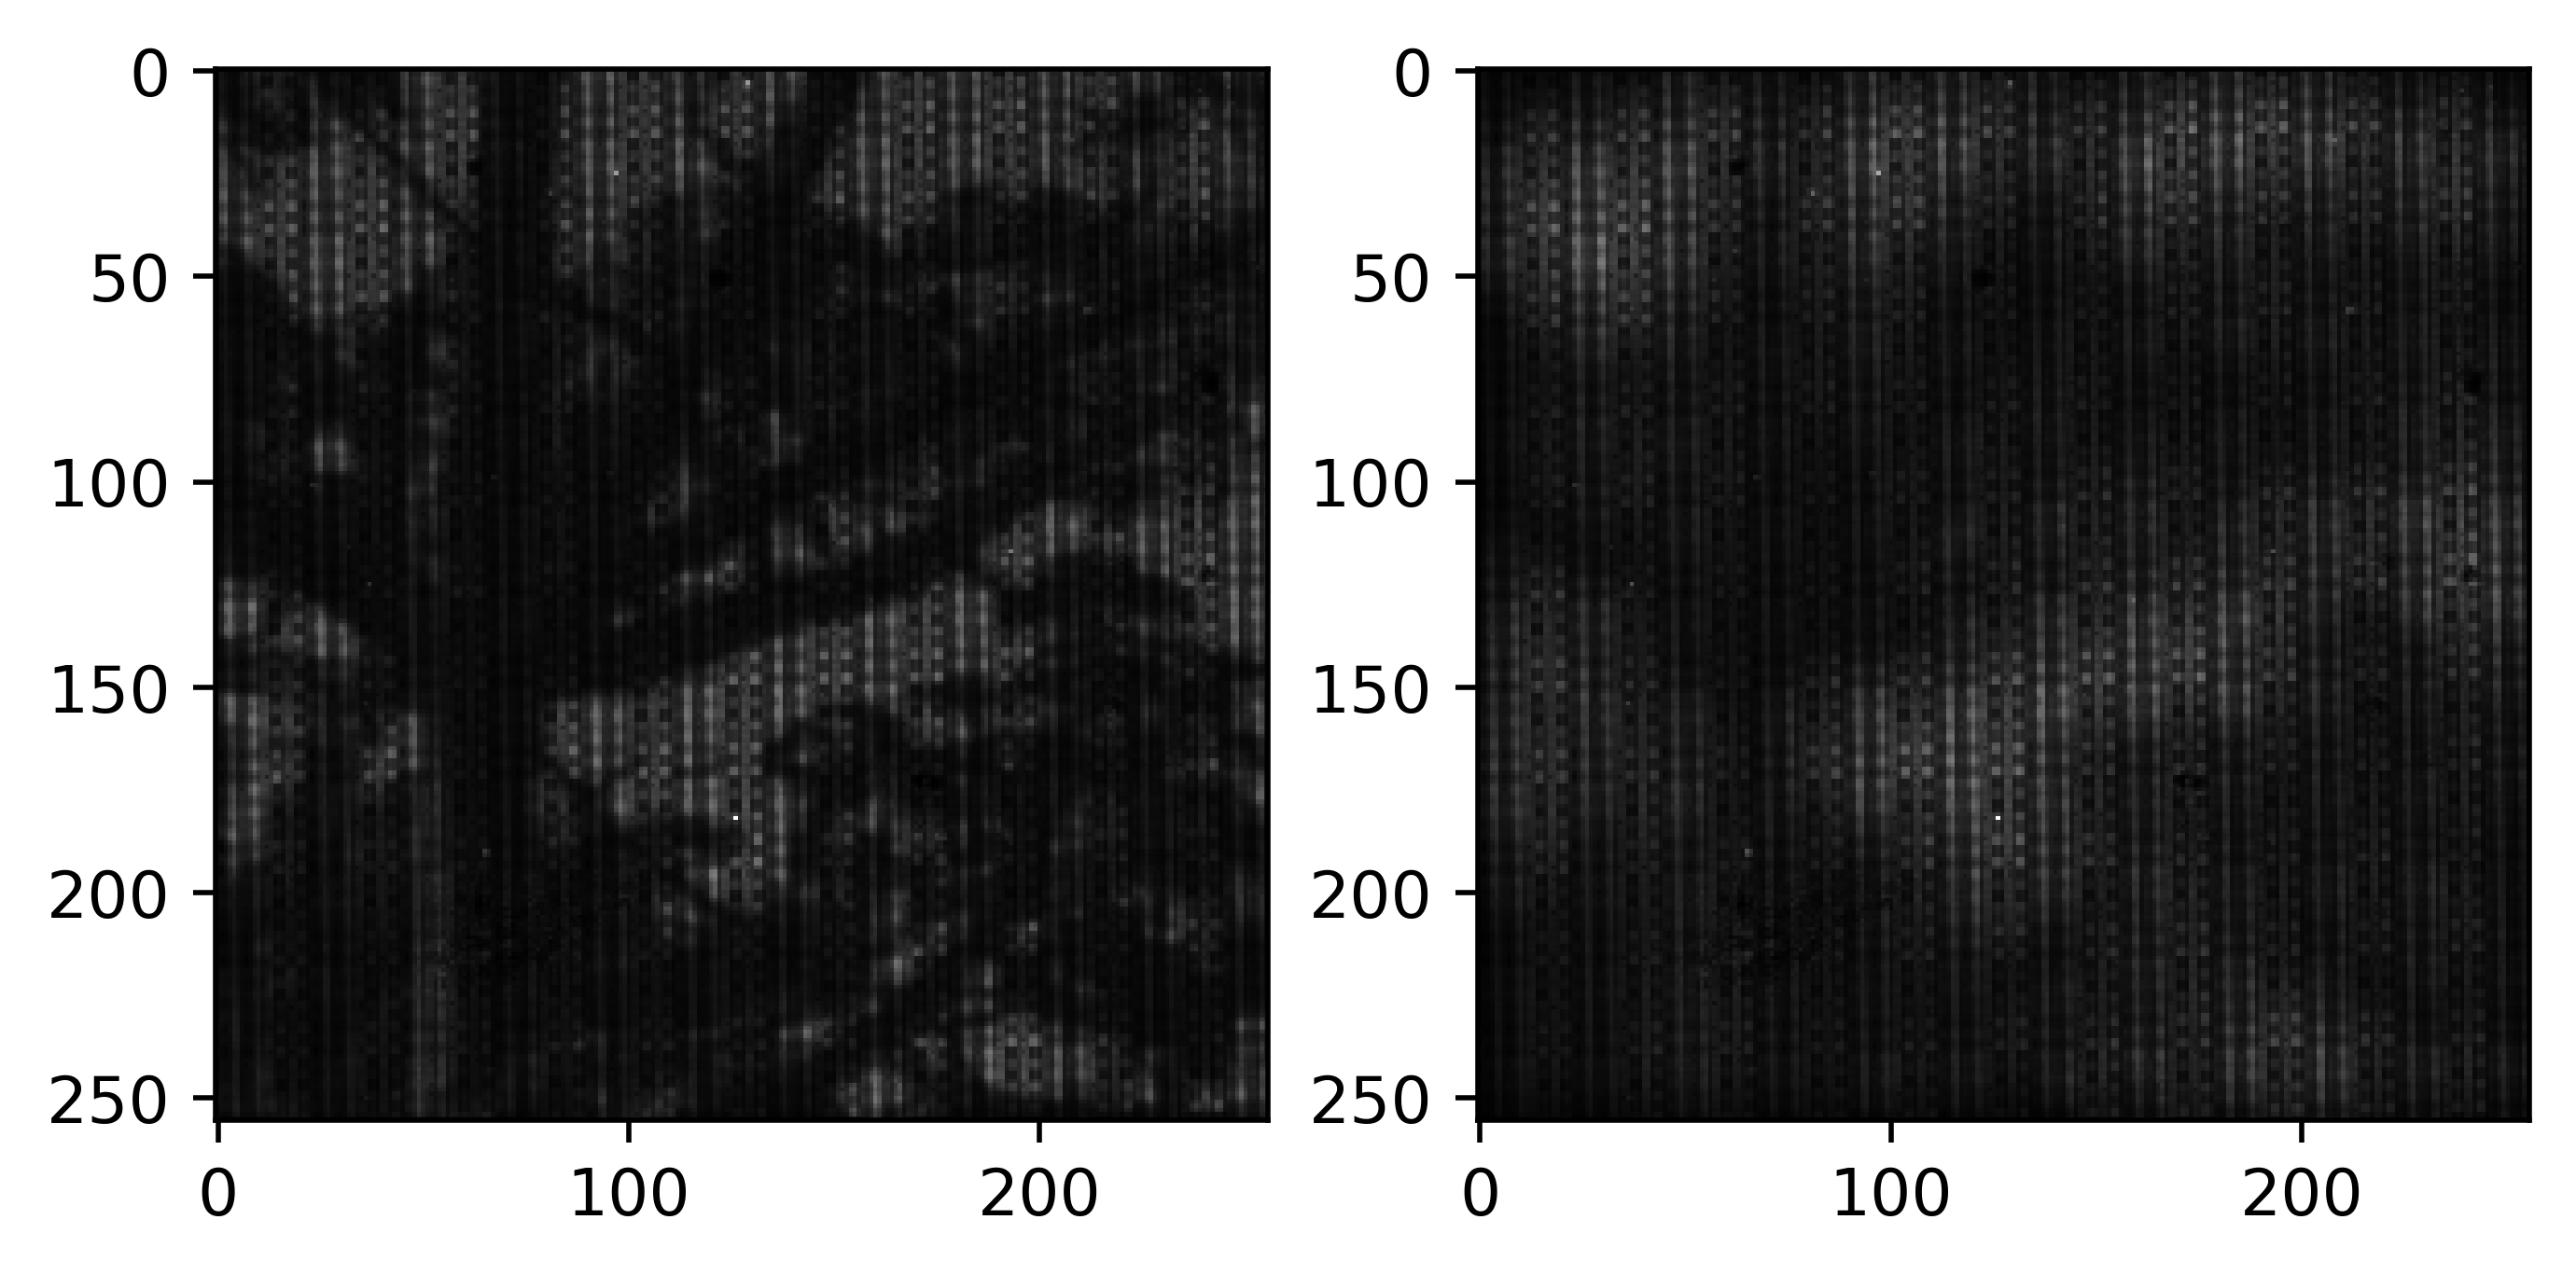

In [45]:
train_loader, val_loader, test_loader = ds.get_data_precomputed(
    batch_size=config["batch_size"],
    data_split=config["data_partition"],
    base_path=config["base_data_path"],
    model_params=config["forward_model_params"],
    norm_target = False,
    shuffle = False,
    workers = 6,
)
sample = test_loader.dataset[36]
gt = sample['image'].cpu().numpy()
sim = sample['input'].cpu().numpy()
test_loader.dataset.file_list[24]

fig, ax = plt.subplots(1,sim.shape[0])
for i in range(sim.shape[0]):
    ax[i].imshow(sim[i,0], cmap = 'gray')


In [46]:
helper.plot_cube_interactive(np.transpose(gt, (1,2,0)), fc_range=(400,700)) 

FigureWidget({
    'data': [{'type': 'image',
              'uid': '0ddc33a8-2cad-42c2-9c1b-566db0c8aea9',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 14,  18,   6],
                           [ 14,  18,   5],
                           [ 15,  19,   6],
                           ..., 
                           [ 81,  68,  30],
                           [ 83,  75,  43],
                           [111,  97,  46]],
                   
                          [[ 17,  20,   7],
                           [ 15,  19,   6],
                           [ 14,  19,   6],
                           ..., 
                           [ 78,  68,  35],
                           [105,  91,  50],
                           [121, 103,  53]],
                   
                          [[ 20,  23,  13],
                           [ 18,  21,   9],
                           [ 15,  19,   6],
                           ..., 
                           [ 76,  67

In [47]:
pred = model.model2(torch.tensor(sim).to(device)[None,...])
pred = helper.value_norm((pred + gt.mean()) * gt.std())

helper.plot_cube_interactive(np.transpose(pred.detach().cpu().numpy()[0], (1,2,0)), fc_range=(400,700))


FigureWidget({
    'data': [{'type': 'image',
              'uid': '0ad1a45c-9c82-4200-8060-2c4b975ab937',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 24,  21,  18],
                           [ 29,  25,  21],
                           [ 23,  20,  19],
                           ..., 
                           [ 73,  77,  61],
                           [ 76,  81,  64],
                           [ 62,  66,  50]],
                   
                          [[ 25,  20,  16],
                           [ 23,  17,  13],
                           [ 17,  12,  12],
                           ..., 
                           [ 68,  72,  57],
                           [ 71,  76,  59],
                           [ 61,  65,  48]],
                   
                          [[ 23,  16,  12],
                           [ 19,  11,   7],
                           [ 14,   9,   8],
                           ..., 
                           [ 64,  69

# Now experiment

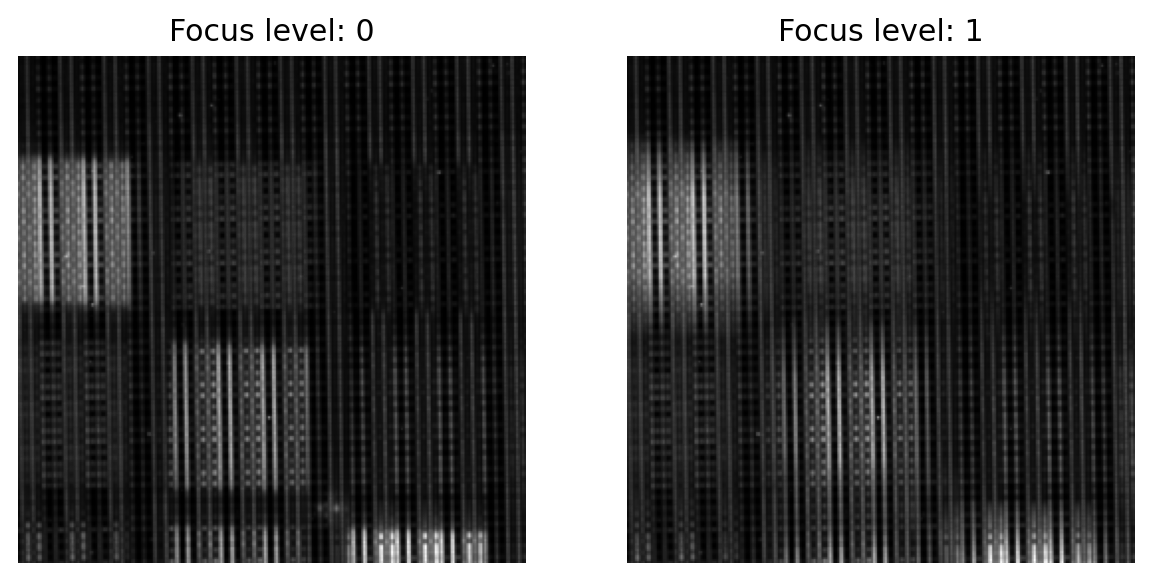

In [48]:
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/hatoncar"
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/mushroom_knife"
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/usaf_negative"
exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/color_palette"
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/rubberband_cards"
    
def preprocess_exp_meas(meas, config):
    # read
    center = config["image_center"]
    dim = config["patch_crop"][0]
    crop = lambda x: x[center[0] -dim//2:center[0]+dim//2, center[1]-dim//2: center[1]+dim//2]
    meas =  crop(np.array(Image.open(meas), dtype=float))

    # downsample
    meas = diffuser_utils.pyramid_down(meas, config["patch_size"])

    #one-normalize
    #meas = (meas - np.min(meas))/(np.max(meas - np.min(meas)))
    return meas

exp_meas = [preprocess_exp_meas(m, config) for m in sorted(glob.glob(os.path.join(exp_meas_path, "*.bmp")))][0::4]

fig, ax = plt.subplots(1, len(exp_meas), figsize = (4*len(exp_meas), 4))
fig.set_dpi(180)
for i,meas in enumerate(exp_meas):
    ax[i].imshow(exp_meas[i], cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
    ax[i].axis('off')
plt.show()

In [49]:
#fm = get_model(config, device, fwd_only=True)

norm = ds.Normalize(0,1)
exp_meas_stack = norm(torch.tensor(np.stack(exp_meas)).to(device)[None, :, None, ...])
print(exp_meas_stack.mean(), exp_meas_stack.std(), exp_meas_stack.shape)

exp_meas_stack.shape


tensor(-1.1102e-16, device='cuda:1', dtype=torch.float64) tensor(1.0000, device='cuda:1', dtype=torch.float64) torch.Size([1, 2, 1, 256, 256])


torch.Size([1, 2, 1, 256, 256])

In [50]:
bias = model.model2((torch.zeros_like(exp_meas_stack)).to(device))[0].detach().cpu().numpy().transpose(1,2,0)
pred = model.model2(exp_meas_stack)[0].detach().cpu().numpy().transpose(1,2,0)

print(pred.shape, bias.shape)

(256, 256, 30) (256, 256, 30)


In [51]:
helper.plot_cube_interactive(helper.value_norm(pred), fc_range=(390, 870), avg_block_size=5)

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'af5de1bd-d653-42aa-91bd-ab6847a864b4',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 41,  43,  34],
                           [ 52,  56,  41],
                           [ 49,  57,  39],
                           ..., 
                           [ 53,  62,  43],
                           [ 58,  63,  46],
                           [ 50,  52,  40]],
                   
                          [[ 41,  43,  34],
                           [ 44,  48,  35],
                           [ 41,  48,  32],
                           ..., 
                           [ 48,  56,  41],
                           [ 50,  57,  43],
                           [ 46,  48,  37]],
                   
                          [[ 39,  41,  30],
                           [ 38,  41,  28],
                           [ 37,  42,  27],
                           ..., 
                           [ 45,  55

In [52]:
unbiased = (pred - np.min(pred)) - np.mean((pred - np.min(pred)), axis=(0,1))
helper.plot_cube_interactive(helper.value_norm(unbiased), fc_range=(390, 870), avg_block_size=5)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '7499b9dc-39ef-4b16-acbe-a2e798da7728',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[16, 28, 68],
                           [28, 43, 75],
                           [26, 43, 74],
                           ..., 
                           [29, 49, 77],
                           [35, 50, 81],
                           [26, 38, 74]],
                   
                          [[17, 28, 67],
                           [20, 34, 69],
                           [16, 33, 66],
                           ..., 
                           [24, 43, 76],
                           [27, 44, 78],
                           [22, 34, 72]],
                   
                          [[14, 25, 63],
                           [14, 26, 61],
                           [12, 27, 60],
                           ..., 
                           [21, 41, 73],
                           [23, 41, 76],

In [11]:
np.save("biased_init", pred), np.save("unbiased_init", unbiased)

(None, None)

In [12]:
helper.plot_cube_interactive(bias, avg_block_size=5)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '05178979-189d-4058-94ee-d2b9cffddf43',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 90,  88,  78],
                           [229, 238, 180],
                           [205, 214, 167],
                           ..., 
                           [166, 184, 223],
                           [213, 233, 228],
                           [143, 154, 160]],
                   
                          [[101, 105,  63],
                           [165, 173, 113],
                           [157, 164, 117],
                           ..., 
                           [119, 136, 191],
                           [174, 193, 187],
                           [142, 156, 149]],
                   
                          [[136, 144, 101],
                           [143, 149, 129],
                           [140, 147, 126],
                           ..., 
                           [110, 125